# Vector embeddings with PyTorch - a whisky recommendation system

The goal of this notebook is to obtain learned vector embeddings for text related to whisky flavor profiles, and create a recommendation system.

I extracted a large set of whisky reviews from Reddit and fed it into a PyTorch neural net to learns the embeddings for each whisky.

This learning task is **supervised**: the training process minimizes the MSE between the learned embeddings and a target 12D vector (whisky flavors over 12 dimensions e.g., smokiness, sweetness, etc.) which I previously obtained via an NLP algorithm based on pattern matching to an existing flavor vocabulary, and sentiment analysis.


##### Loading packages

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
import numpy as np
import random
import pickle
from collections import defaultdict
import matplotlib.pyplot as pl

##### Hyper-parameters
Variations of the numbers below were tested a few times before reaching the final version presented here

In [2]:
#hyper-parameters and data used in this notebook:
hyper = {
        'datafile' : 'data/whisky_data.pickle', #filename 
        'tf_idf_max' : 10_000, # maximum number of unique words in tf-idf vectorization
        'batch_size' : 64, # number of inputs per batch
        'train_size' : 0.80, # percentage of data to be considered for training (validation size = 1.0 - train_size)    
        'dropout' : 0.30, #percentage of neurons disabled
        'learning_rate' : 1e-3, #Adam optimizer learning rate
        'weight_decay' : 1e-4, # Size of L2 regularization  
        'embedding_dim' : 36, # number of hidden layer embedding dimensions
        }

### Read original data

In [3]:
with open(hyper['datafile'],'rb') as file:
    data = pickle.load(file)
#data dictionary format: {'Lagavulin 16': {
#                         'review': [review1, review2 , ...], <---individual reddit reviews
#                         'hist': np.array([...])             <---feature-engineered flavor profiles (target variable)
#                                         }
#                        }

### Pre-process the data to feed into Neural Net

In [4]:
# Build a list of every review + its whisky's flavor histogram
all_reviews   = []        # list of review strings  (N_reviews,)
all_flav_vecs = []        # list of 1-D numpy arrays (same length)

for whisky, info in data.items():             
    flav_vec = info["hist"]                   # shape (12,) meaning 12 flavor dimensions
    for rev in info["reviews"]:               
        all_reviews.append(rev)
        all_flav_vecs.append(flav_vec)          

print(f"Total reviews: {len(all_reviews)}")     

# Use TF-IDF to vectorize each review (10 000-dim limit)
vectorizer = TfidfVectorizer(max_features=hyper['tf_idf_max'],              
                             min_df=2,                         # drop 1-off words
                             stop_words="english")             # English stopwords

X_sparse = vectorizer.fit_transform(all_reviews)               # sparse matrix, shape (N_reviews, 10000)

# Build target array  
Y = np.vstack(all_flav_vecs)  # shape (N_reviews, 12)

Total reviews: 8089


### Dataset & DataLoader for PyTorch pipeline

In [5]:
# Create Dataset and DataLoader
class WhiskyDataset(Dataset):
    def __init__(self, X_csr, Y_nd):
        self.X = X_csr
        self.Y = torch.tensor(Y_nd, dtype=torch.float32)

    def __len__(self): 
        return self.X.shape[0]

    def __getitem__(self, idx):
        # convert one row to dense matrix on the fly 
        x_dense = torch.tensor(self.X[idx].toarray(), dtype=torch.float32).squeeze(0)
        return x_dense, self.Y[idx]


dataset = WhiskyDataset(X_sparse, Y)        # X_sparse & Y built on previous cell
train_set, val_set = torch.utils.data.random_split(dataset, [int( hyper['train_size'] *len(dataset)),
                                                             len(dataset)-int(hyper['train_size']*len(dataset))]) #80%/20% split for training/validation
train_loader = DataLoader(train_set, batch_size=hyper['batch_size'], shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=hyper['batch_size'])

### Defining the model

In [6]:
# Define the Model
class EmbeddingRegressor(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, embed_dim)  #fully connected
        self.drop = nn.Dropout(p=hyper['dropout'])      #30% dropout to avoid overfitting  
        self.relu    = nn.ReLU()                        #ReLU for activation
        self.linear2 = nn.Linear(embed_dim, output_dim) #output matching 12 flavor dimensions of target

    def forward(self, x):
        h = self.relu(self.linear1(x))   
        h = self.drop(h)
        return self.linear2(h)

    def get_embedding(self, x):
        with torch.no_grad():
            return self.relu(self.linear1(x)).cpu().numpy()

input_dim, embed_dim, output_dim = X_sparse.shape[1], hyper['embedding_dim'], Y.shape[1] #embedding dimensionality is 36
model = EmbeddingRegressor(input_dim, embed_dim, output_dim)

# Define Optim / Loss
loss_fn  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hyper['learning_rate'], weight_decay=hyper['weight_decay'])

### Training loop

In [7]:
def training_loop(N_Epochs=200, patience=10) -> dict: 
    '''
    N_Epochs: how long to train the neural net for
    patience: early-stopping parameter (stops training if loss hasn't improved from best value after this many steps)
    returns dict with diagnostics (loss, r^2 score) 
    '''
    diagnostics = defaultdict(list) # dictionary for outputs and fit metrics
    best_val = float('inf')
    bad_epochs = 0 #early-stopping when this reaches patience
    
    for epoch in range(N_Epochs):
        #train
        model.train()
        tot = 0 #total loss
        for x, y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            tot += loss.item() * x.size(0)
        train_loss = tot / len(train_loader.dataset) #training loss (averaged per data point)
    
        # validate
        model.eval()
        val_tot   = 0 #total validation loss
        y_true_ls = []
        y_pred_ls = []
    
        with torch.no_grad():
            for x, y in val_loader:
                out = model(x)
                val_tot += loss_fn(out, y).item() * x.size(0)
    
                # save for metrics
                y_true_ls.append(y.cpu().numpy())
                y_pred_ls.append(out.cpu().numpy())
    
        val_loss = val_tot / len(val_loader.dataset)
        
        #early stopping to avoid overfitting
        if val_loss < best_val:   # improvement was found
            best_val = val_loss
            bad_epochs = 0
            torch.save(model.state_dict(), "best_whisky_model_v2.pth")
        else:
            bad_epochs += 1       # increment number of epochs without improvement  
            if bad_epochs == patience:
                print("Early-stopping.")
                break
    
        # additional metrics 
        y_true = np.vstack(y_true_ls)          # shape (N_validation, 12)
        y_pred = np.vstack(y_pred_ls)
        val_r2 = r2_score(y_true, y_pred)      # one value for the whole set
        
        print(f"Epoch: {epoch+1:03d} -- Train: {train_loss:.3e} -- Val: {val_loss:.3e} -- Val R2: {val_r2:.3f}")
        diagnostics['train_loss'].append(train_loss)
        diagnostics['val_loss'].append(val_loss)
        diagnostics['val_r2'].append(val_r2)

    return diagnostics

In [8]:
#Run the training
diagnostics = training_loop()

Epoch: 001 -- Train: 4.196e+00 -- Val: 1.754e+00 -- Val R2: -0.618
Epoch: 002 -- Train: 1.379e+00 -- Val: 1.011e+00 -- Val R2: -0.234
Epoch: 003 -- Train: 1.037e+00 -- Val: 8.655e-01 -- Val R2: -0.093
Epoch: 004 -- Train: 8.727e-01 -- Val: 7.265e-01 -- Val R2: 0.031
Epoch: 005 -- Train: 7.330e-01 -- Val: 6.174e-01 -- Val R2: 0.111
Epoch: 006 -- Train: 6.339e-01 -- Val: 5.406e-01 -- Val R2: 0.167
Epoch: 007 -- Train: 5.828e-01 -- Val: 4.948e-01 -- Val R2: 0.200
Epoch: 008 -- Train: 5.405e-01 -- Val: 4.671e-01 -- Val R2: 0.223
Epoch: 009 -- Train: 5.123e-01 -- Val: 4.538e-01 -- Val R2: 0.226
Epoch: 010 -- Train: 4.820e-01 -- Val: 4.378e-01 -- Val R2: 0.248
Epoch: 011 -- Train: 4.734e-01 -- Val: 4.266e-01 -- Val R2: 0.259
Epoch: 012 -- Train: 4.602e-01 -- Val: 4.217e-01 -- Val R2: 0.264
Epoch: 013 -- Train: 4.477e-01 -- Val: 4.202e-01 -- Val R2: 0.264
Epoch: 014 -- Train: 4.316e-01 -- Val: 4.078e-01 -- Val R2: 0.282
Epoch: 015 -- Train: 4.224e-01 -- Val: 4.037e-01 -- Val R2: 0.288
Epoch: 

## Validation checks

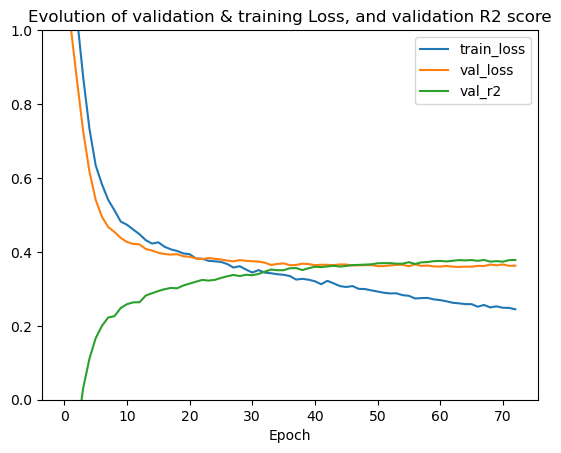

In [9]:
def plot_diagnostics(diagnostics: dict):
    pl.figure()
    pl.title('Evolution of validation & training Loss, and validation R2 score')
    for key in diagnostics:
        pl.plot(diagnostics[key],label=key)
    pl.ylim(0,1)
    pl.xlabel('Epoch')
    pl.legend(loc=0)
    pl.show()

plot_diagnostics(diagnostics)

## Visualize embeddings 

Pre-process the data to get whisky names and a color map

In [10]:
X_dense  = X_sparse.toarray().astype("float32")      # (N_reviews , 10 000)
X_tensor = torch.from_numpy(X_dense)

# get embeddings for *every* review
emb_reviews = model.get_embedding(X_tensor)          # (N_reviews , embed_dim)

unique   = sorted(set(data.keys()))            # get whisky names

cmap = pl.get_cmap('turbo')          
colors = cmap(np.linspace(0, 1, len(unique))) # sampling colors across a colormap
color_of = {lbl: col for lbl, col in zip(unique, colors)} #color dictionary

names_list = [] #getting a list of whisky names with repetitions to correpond to each review
for name in data.keys():
    number_of_repeats = len(data[name]['reviews'])
    for _ in range(number_of_repeats):
        names_list.append(name)

Visualize embeddings via TSNE

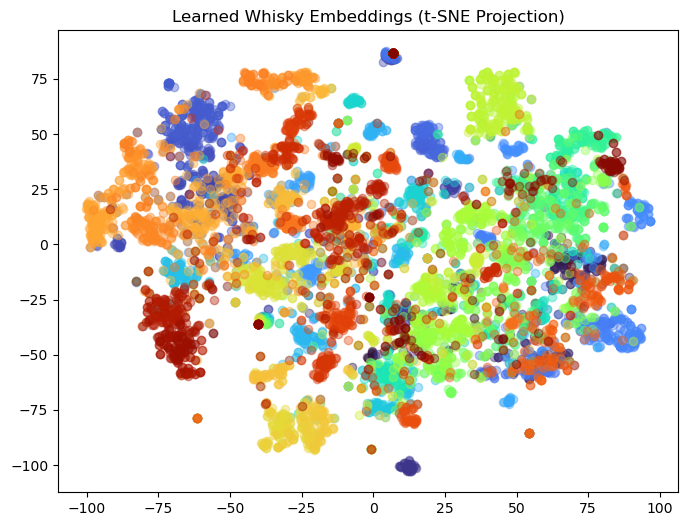

In [11]:
tsne = TSNE(n_components=2, perplexity=15) #Use TSNE to reduce dimensionality, PCA would also work
X_2d = tsne.fit_transform(emb_reviews)

pl.figure(figsize=(8, 6))
for i in range(len(X_2d[:, 0])):
    pl.scatter(X_2d[i, 0], X_2d[i, 1], alpha=0.4,color=color_of[names_list[i]])
pl.title("Learned Whisky Embeddings (t-SNE Projection)")
pl.show()

### Making a prediction of which whisky best correponds to a given user input text

The basic idea is:

1- User inputs text requesting a whisky recommendation with a specific flavor profile

2- Input is vectorized via TF-IDF

3- The model predicts the 12-D flavor profile vector (embedding)

4- We rank the cosine similarity between the user's flavor profile vector and the existing whisky vectors

5- We return the best matches

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

#preprocess the data
flavor_vectors = np.zeros(( len(data.keys()), len(data['Aberfeldy 12']['hist']) ))
for i,name in enumerate(data.keys()):
    flavor_vectors[i,:] = data[name]['hist'] 
print(flavor_vectors.shape) 
whisky_names = list(data.keys())

def recommend_whiskies(user_input_text: str, 
                       model: 'trained model', 
                       vectorizer: 'tf-idf vectorizer', 
                       known_flavor_vectors: list, 
                       whisky_names: list, 
                       top_n_matches=3) -> str:
    model.eval()
    user_vec = vectorizer.transform([user_input_text]).toarray() #vectorize the user's input
    with torch.no_grad():
        user_pred = model(torch.tensor(user_vec, dtype=torch.float32)).numpy() #predict 12D flavors (embedding)
    sims = cosine_similarity(user_pred, known_flavor_vectors)[0] #get cosine similarities with known whiskies
    top_indices = sims.argsort()[::-1][:top_n_matches]
    return [(whisky_names[i], float(sims[i])) for i in top_indices] #return top N best aligned whiskies

(128, 12)


In [15]:
test_inputs = [
    "I want a light, floral, and delicate whisky with hints of green apple",
    "Recommend a whisky with strong peat, brine, and smoke notes",
    "Notes of red fruits and berries, with balanced peat and full body"
]

for user_input in test_inputs:
    print('User input:', user_input)
    recommendations = recommend_whiskies(
        user_input, model, vectorizer, known_flavor_vectors=flavor_vectors, whisky_names=whisky_names)
    for name, score in recommendations:
        print(f"--> {name} — similarity: {score:.4f}")
    print('\n')

User input: I want a light, floral, and delicate whisky with hints of green apple
--> AnCnoc 12 — similarity: 0.9980
--> Glenfiddich 12 — similarity: 0.9970
--> Glenlivet 12 — similarity: 0.9968


User input: Recommend a whisky with strong peat, brine, and smoke notes
--> Lagavulin 16 — similarity: 0.9981
--> Ardbeg Corryvreckan — similarity: 0.9967
--> Laphroaig 18 — similarity: 0.9962


User input: Notes of red fruits and berries, with balanced peat and full body
--> Springbank 10 — similarity: 0.9944
--> Springbank 15 — similarity: 0.9936
--> Benromach 10 — similarity: 0.9896


